Working with real-world data: change detection with Sentinel-2 imagery
===

In this notebook, we fetch Sentinel-2 imagery for the same area for 2 different timestamps and the detect the changes between them using a pre-trained change detection model. This is the same model as discussed in [this blog post](https://element84.com/machine-learning/change-detection-with-raster-vision/).

---

# Using a STAC API

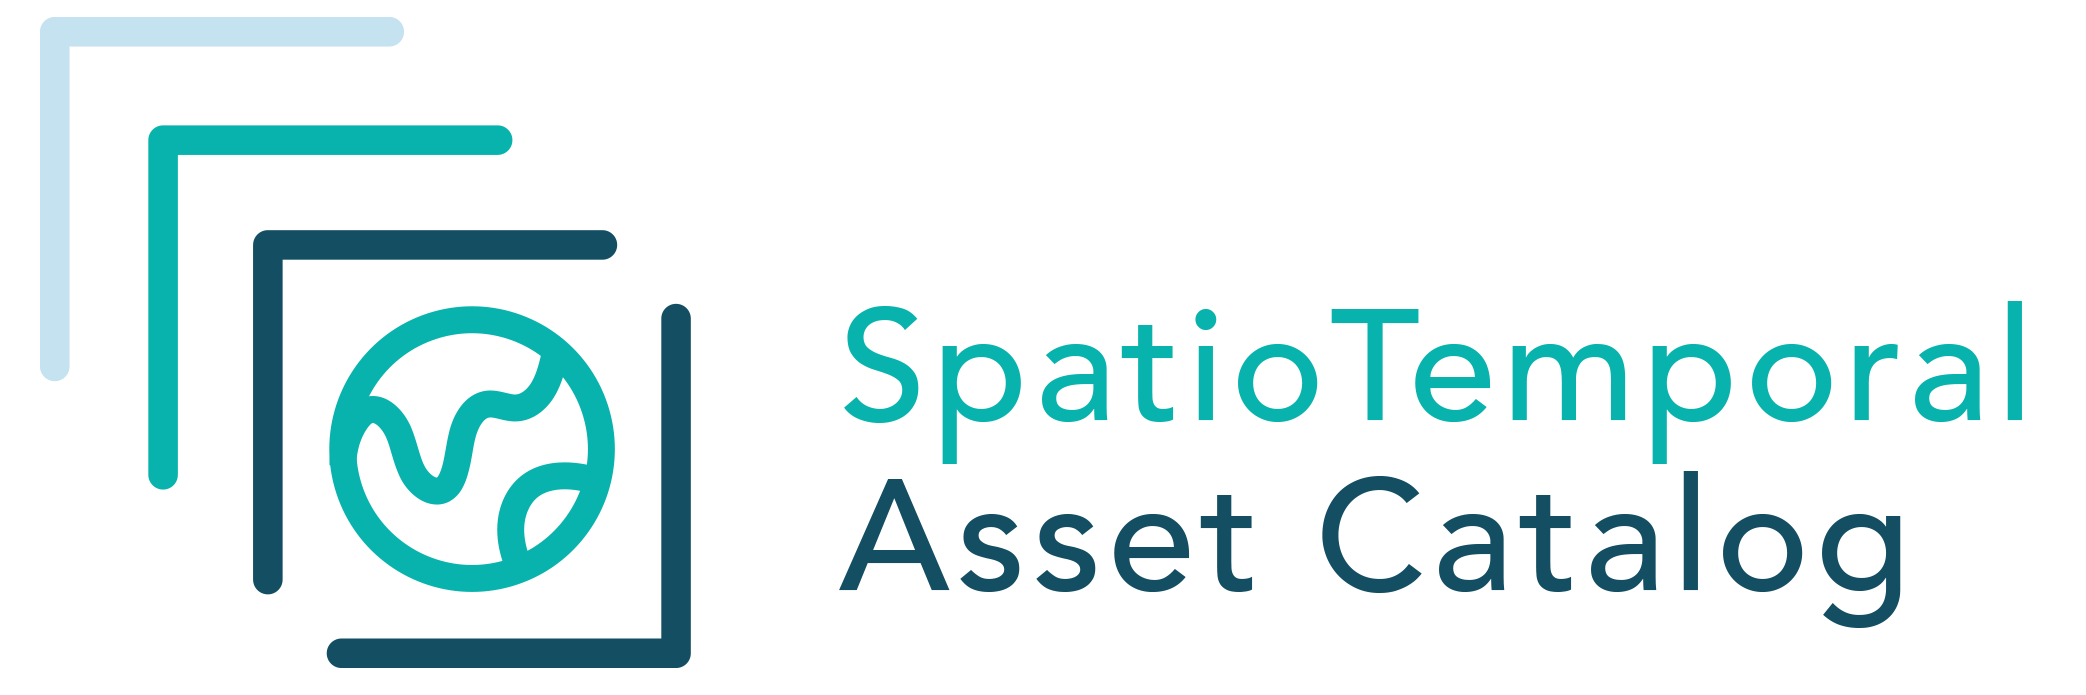

In [ ]:
from os.path import join

In [ ]:
BANDS = [
    'coastal',  # B01
    'blue',  # B02
    'green',  # B03
    'red',  # B04
    'rededge1',  # B05
    'rededge2',  # B06
    'rededge3',  # B07
    'nir',  # B08
    'nir09',  # B09
    'swir16',  # B11
    'swir22',  # B12
    'nir08',  # B8A
]

Raster Vision can also work with HTTPS URIs:

In [ ]:
model_bundle_uri = 'https://azavea-research-public-data.s3.amazonaws.com/raster-vision/examples/s2-change-detection/model-bundle.zip'
stats_uri = 'https://azavea-research-public-data.s3.amazonaws.com/raster-vision/examples/s2-change-detection/stats.json'

In [ ]:
# out_dir = 's3://ml-workshop-internal/2024_05_02/<YOUR_NAME>/s2_change_detection/'

In [ ]:
out_dir = 'data/s2_change_detection/'

In [ ]:
from rastervision.core.box import Box

bbox = Box(ymin=36.046048, xmin=-114.972675, ymax=35.985617, xmax=-114.911484)
bbox

In [ ]:
bbox_polygon = bbox.to_shapely().oriented_envelope
bbox_polygon

In [ ]:
from shapely.geometry import mapping

search_geometry = mapping(bbox_polygon)
search_geometry

In [ ]:
import pystac_client

catalog = pystac_client.Client.open(
    'https://earth-search.aws.element84.com/v1')

items_old = catalog.search(
    intersects=search_geometry,
    datetime='2017-04-01/2017-05-01',
    collections=['sentinel-2-l2a'],
    query={
        'eo:cloud_cover': {
            'lt': 5
        }
    },
).item_collection()
items_old

In [ ]:
items_new = catalog.search(
    intersects=search_geometry,
    datetime='2024-04-01/2024-05-01',
    collections=['sentinel-2-l2a'],
    query={
        'eo:cloud_cover': {
            'lt': 5
        }
    },
).item_collection()
items_new

In [ ]:
item_old = items_old[0]
item_new = items_new[0]

In [ ]:
import contextily as cx
from matplotlib import pyplot as plt
from matplotlib import patches

fig, ax = plt.subplots(figsize=(6, 6))

bbox_geometry = patches.Polygon(bbox.to_points(), color='r', fill=False)
ax.add_patch(bbox_geometry)

item_old_geometry = patches.Polygon(item_old.geometry['coordinates'][0],
                                    color='k',
                                    fill=False)
ax.add_patch(item_old_geometry)

item_new_geometry = patches.Polygon(item_new.geometry['coordinates'][0],
                                    color='steelblue',
                                    fill=False)
ax.add_patch(item_new_geometry)

ax.autoscale()
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager)
plt.show()

---

# Predicting with the Raster Vision `predict_scene` CLI command

In [ ]:
!rastervision predict_scene --help

In [ ]:
from rastervision.pipeline.file_system.utils import json_to_file

item_uri_old = join(out_dir, 'stac-item-t1.json')
json_to_file(item_old.to_dict(), item_uri_old)

item_uri_new = join(out_dir, 'stac-item-t2.json')
json_to_file(item_new.to_dict(), item_uri_new)

In [ ]:
from rastervision.core.data import (STACItemConfig, StatsTransformerConfig,
                                    XarraySourceConfig)

raster_source_old_config = XarraySourceConfig(
    stac=STACItemConfig(uri=item_uri_old, assets=BANDS),
    channel_order=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 11],
    stackstac_args=dict(rescale=False, fill_value=0, dtype='uint16'),
    transformers=[StatsTransformerConfig(stats_uri=stats_uri)],
    bbox_map_coords=tuple(bbox),
    allow_streaming=False,
)

In [ ]:
raster_source_new_config = XarraySourceConfig(
    stac=STACItemConfig(uri=item_uri_new, assets=BANDS),
    channel_order=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 11],
    stackstac_args=dict(rescale=False, fill_value=0, dtype='uint16'),
    transformers=[StatsTransformerConfig(stats_uri=stats_uri)],
    bbox_map_coords=tuple(bbox),
    allow_streaming=False,
)

In [ ]:
from rastervision.core.data import MultiRasterSourceConfig

raster_source_config = MultiRasterSourceConfig(
    raster_sources=[raster_source_old_config, raster_source_new_config])

In [ ]:
from rastervision.core.data import (SemanticSegmentationLabelStoreConfig,
                                    PolygonVectorOutputConfig)

label_store_config = SemanticSegmentationLabelStoreConfig(
    uri=out_dir,
    smooth_output=True,
    vector_output=[
        PolygonVectorOutputConfig(
            # class ID of the "change" class
            class_id=1,
            # threshold to use for creating binary mask that will then be vectorized
            threshold=0.25,
            # filter out positive regions in the binary mask smaller than
            # this diameter (in pixels)
            denoise=8,
        ),
    ],
)

In [ ]:
from rastervision.core.data.utils import geoms_to_geojson
from shapely.geometry import shape

aoi_geom = shape(item_old.geometry).intersection(shape(item_new.geometry))
aoi_geojson = geoms_to_geojson([aoi_geom])
aoi_uri = join(out_dir, 'aoi.json')
json_to_file(aoi_geojson, aoi_uri)

In [ ]:
from rastervision.core.data import SceneConfig

scene_config = SceneConfig(
    id='',
    raster_source=raster_source_config,
    label_store=label_store_config,
    aoi_uris=[aoi_uri],
)

In [ ]:
from rastervision.core.rv_pipeline import SemanticSegmentationPredictOptions

pred_opts = SemanticSegmentationPredictOptions(chip_sz=100,
                                               stride=50,
                                               crop_sz='auto')

In [ ]:
scene_config_uri = join(out_dir, 'scene-config.json')
scene_config.to_file(scene_config_uri)

pred_opts_uri = join(out_dir, 'pred-opts.json')
pred_opts.to_file(pred_opts_uri)

In [ ]:
!TMPDIR=data/tmp/ rastervision predict_scene {model_bundle_uri} {scene_config_uri} --predict_options_uri {pred_opts_uri}

---

# Inpect results in QGIS

- Find the href of the `visual` asset for each item and download it
- Load both in QGIS, so we can switch back and forth between them
- Load the model's predictions
- Do the predictions make sense? How good are they?

In [ ]:
item_old

In [ ]:
item_new

---

## AWS SageMaker

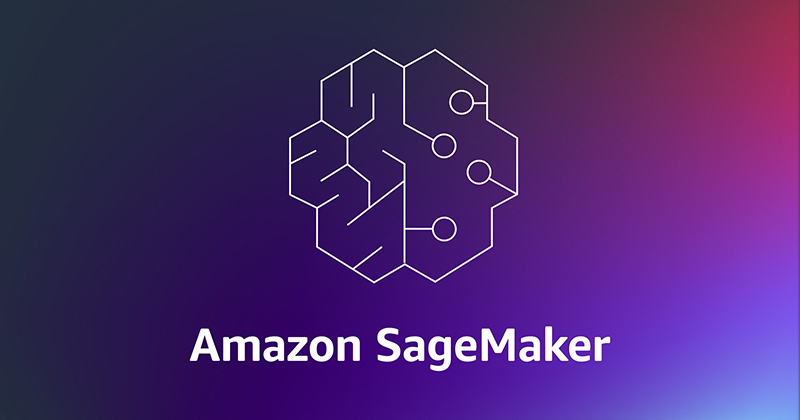

>SageMaker, SageMaker, you're the one I choose,  
From data prep to model deploy, I never lose.  
Jupyter Notebooks, Python code, we're ready to cruise,  
With SageMaker, SageMaker, I never get the blues.  

― GPT-4 on SageMaker

In [ ]:
from rastervision.aws_sagemaker import AWSSageMakerRunner

runner = AWSSageMakerRunner()

In [ ]:
runner.run_command(
    cmd=[
        'rastervision', 'predict_scene', model_bundle_uri, scene_config_uri,
        '--predict_options_uri', pred_opts_uri
    ],
    role='SageMaker-MLWorkshopParticipant',
    image_uri=
    '992382462803.dkr.ecr.us-east-1.amazonaws.com/raster-vision-pytorch',
    instance_type='ml.p3.2xlarge',
    job_name='ml-workshop-s2-change-detection',
)

In [ ]:
!aws s3 ls {out_dir}